In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install catboost
import catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 kB 3.3 MB/s eta 0:00:00


In [ ]:
!pip install lightgbm
import lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 37.3 MB/s eta 0:00:00


In [ ]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.9/295.9 MB 1.9 MB/s eta 0:00:00


In [ ]:
!pip install catboost
from catboost import CatBoostRegressor

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error,roc_auc_score
from lightgbm import LGBMRegressor


In [ ]:
from sklearn.ensemble import RandomForestRegressor


In [ ]:
# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/merged_data.csv')

In [ ]:
# Step 1: Identify rare and common side effects
side_effect_counts = df['side_effect_name'].value_counts()
rare_side_effects = side_effect_counts[side_effect_counts < 1550].index  # Adjust threshold as needed
common_side_effects = side_effect_counts[side_effect_counts >= 1550].index

# Step 2: Keep all rare side effect records, sample common ones
rare_df = df[df['side_effect_name'].isin(rare_side_effects)]
common_df = df[df['side_effect_name'].isin(common_side_effects)].groupby('side_effect_name').sample(frac=0.1, random_state=42)

# Step 3: Combine datasets
downsampled_df = pd.concat([rare_df, common_df])

# Step 4: Shuffle the final dataset
downsampled_df = downsampled_df.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Dataset reduced from {len(df)} to {len(downsampled_df)} records.")

Dataset reduced from 9312040 to 2071000 records.


In [ ]:
# Preprocess text columns
downsampled_df['side_effect_name'] = downsampled_df['side_effect_name'].fillna("").str.lower()
downsampled_df['meddra_indication_name'] = downsampled_df['meddra_indication_name'].fillna("").str.lower()

# Apply TF-IDF
vectorizer = TfidfVectorizer(max_features=50)
side_effect_tfidf = vectorizer.fit_transform(downsampled_df['side_effect_name']).toarray()
indication_tfidf = TfidfVectorizer(max_features=50).fit_transform(downsampled_df['meddra_indication_name']).toarray()

# Add TF-IDF features to DataFrame
se_tfidf_df = pd.DataFrame(side_effect_tfidf, columns=[f'tfidf_{i}' for i in range(50)])
indication_tfidf_df = pd.DataFrame(indication_tfidf, columns=[f'ind_tfidf_{i}' for i in range(50)])
downsampled_df = pd.concat([downsampled_df, se_tfidf_df, indication_tfidf_df], axis=1)

In [ ]:
# Calculate side effect frequencies
side_effect_counts = downsampled_df['side_effect_name'].value_counts().to_dict()
downsampled_df['side_effect_freq'] = downsampled_df['side_effect_name'].map(side_effect_counts)

# Normalize side effect frequency
downsampled_df['side_effect_freq'] = (downsampled_df['side_effect_freq'] / downsampled_df['side_effect_freq'].max()).clip(0, 1)

In [ ]:
# Calculate co-occurrence of indication and side effect
co_occurrence = downsampled_df.groupby(['meddra_indication_name', 'side_effect_name']).size().reset_index(name='co_occurrence_count')
downsampled_df = downsampled_df.merge(co_occurrence, on=['meddra_indication_name', 'side_effect_name'], how='left')

# Calculate indication frequency
indication_counts = downsampled_df['meddra_indication_name'].value_counts().to_dict()
downsampled_df['indication_freq'] = downsampled_df['meddra_indication_name'].map(indication_counts)

# Calculate indication-side effect relevance
downsampled_df['indication_side_effect_relevance'] = (downsampled_df['co_occurrence_count'] / downsampled_df['indication_freq']).fillna(0).clip(0, 1)

In [ ]:
# Calculate drug-side effect co-occurrence
drug_side_effect_co_occurrence = downsampled_df.groupby(['drug_name', 'side_effect_name']).size().reset_index(name='drug_side_effect_count')
downsampled_df = downsampled_df.merge(drug_side_effect_co_occurrence, on=['drug_name', 'side_effect_name'], how='left')

# Calculate total occurrences of each drug
drug_total_counts = downsampled_df.groupby('drug_name').size().reset_index(name='drug_total_count')
downsampled_df = downsampled_df.merge(drug_total_counts, on='drug_name', how='left')

# Calculate drug-side effect relevance
downsampled_df['drug_side_effect_relevance'] = (downsampled_df['drug_side_effect_count'] / downsampled_df['drug_total_count']).fillna(0).clip(0, 1)

In [ ]:
# One-hot encode drug names
drug_name_ohe = pd.get_dummies(downsampled_df['drug_name'], prefix='drug')
downsampled_df = pd.concat([downsampled_df, drug_name_ohe], axis=1)

In [ ]:
downsampled_df['adverse_reaction_probability'] = (
    0.5 * downsampled_df['side_effect_freq'] +
    0.3 * downsampled_df['indication_side_effect_relevance'] +
    0.2 * downsampled_df['drug_side_effect_relevance']
).clip(0, 1)

In [ ]:
# Drop problematic features
downsampled_df.drop(columns=['side_effect_freq', 'indication_side_effect_relevance', 'drug_side_effect_relevance'], inplace=True)
downsampled_df.drop(columns=['stitch_id_flat', 'umls_id_se', 'concept_type', 'side_effect_name',
                             'meddra_type', 'umls_id2', 'meddra_indication_name', 'drug_name'], inplace=True)


In [ ]:

# Define feature and target columns
feature_cols = [col for col in downsampled_df.columns if col != 'adverse_reaction_probability']
X = downsampled_df[feature_cols]
y = downsampled_df['adverse_reaction_probability']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
lgbm = LGBMRegressor(
    n_estimators=100,
    reg_lambda=0.1,

    min_child_samples=20,
    random_state=42,
    max_depth=5
)

In [ ]:
lgbm.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 2.545165 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5398
[LightGBM] [Info] Number of data points in the train set: 1449700, number of used features: 1307
[LightGBM] [Info] Start training from score 0.086885
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

LGBMRegressor(max_depth=5, random_state=42, reg_lambda=0.1)

In [ ]:
# Predict and evaluate
lgm_pred = lgbm.predict(X_test)

print("Mean Squared Error:", mean_squared_error(y_test, lgm_pred))
print("R² Score:", r2_score(y_test, lgm_pred))



/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Mean Squared Error: 0.003706500134530218
R² Score: 0.4562420172743613


In [ ]:
from xgboost import XGBRegressor

In [ ]:
xgbregressor=XGBRegressor(n_estimators=30,
                          max_depth=5,
                          random_state=42,

                          n_jobs=-1,
                          reg_lambda=0.2,
                         reg_alpha=0.1,)


In [ ]:
xgbregressor.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=30,
             n_jobs=-1, num_parallel_tree=None, ...)

In [ ]:
xgb_pred=xgbregressor.predict(X_test)
print("Mean Squared Error:", mean_squared_error(y_test, xgb_pred))
print("R-Squared Score:", r2_score(y_test, xgb_pred))

Mean Squared Error: 0.003744963038321572
R-Squared Score: 0.4505993597224258


In [ ]:
catboost_model= CatBoostRegressor(n_estimators=600)

In [ ]:
catboost_model.fit(X_train,y_train)

Learning rate set to 0.195896
0:	learn: 0.0785347	total: 144ms	remaining: 1m 26s
1:	learn: 0.0756835	total: 229ms	remaining: 1m 8s
2:	learn: 0.0733793	total: 323ms	remaining: 1m 4s
3:	learn: 0.0715798	total: 410ms	remaining: 1m 1s
4:	learn: 0.0703961	total: 494ms	remaining: 58.8s
5:	learn: 0.0693844	total: 579ms	remaining: 57.3s
6:	learn: 0.0684974	total: 666ms	remaining: 56.4s
7:	learn: 0.0677593	total: 752ms	remaining: 55.6s
8:	learn: 0.0672864	total: 836ms	remaining: 54.9s
9:	learn: 0.0668547	total: 917ms	remaining: 54.1s
10:	learn: 0.0665416	total: 989ms	remaining: 53s
11:	learn: 0.0661752	total: 1.07s	remaining: 52.5s
12:	learn: 0.0658750	total: 1.16s	remaining: 52.5s
13:	learn: 0.0655229	total: 1.24s	remaining: 52s
14:	learn: 0.0653410	total: 1.31s	remaining: 51.2s
15:	learn: 0.0651177	total: 1.39s	remaining: 50.6s
16:	learn: 0.0648700	total: 1.48s	remaining: 50.8s
17:	learn: 0.0646896	total: 1.56s	remaining: 50.4s
18:	learn: 0.0645455	total: 1.64s	remaining: 50.2s
19:	learn: 0.0

In [ ]:
catboost_pred=catboost_model.predict(X_test)
print("Mean Squared Error:", mean_squared_error(y_test, catboost_pred))
print("R-Squared Score:", r2_score(y_test, catboost_pred))

Mean Squared Error: 0.00315331149084309
R-Squared Score: 0.5373969424167477


In [ ]:
#get the predictions again
xgb_pred=xgbregressor.predict(X_test)
lgbm_pred=lgbm.predict(X_test)
cat_pred=catboost_model.predict(X_test)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [ ]:
stacked_predictions= np.column_stack((xgb_pred,lgbm_pred,cat_pred))

In [ ]:
meta_model = RandomForestRegressor(n_estimators=30, n_jobs=-1)

In [ ]:
meta_model.fit(stacked_predictions,y_test)

RandomForestRegressor(n_estimators=30, n_jobs=-1)

In [ ]:
meta_model_pred=meta_model.predict(stacked_predictions)

In [ ]:
import joblib
# Save TF-IDF vectorizers
joblib.dump(side_effect_tfidf, 'tfidf_side_effect.pkl')
joblib.dump(indication_tfidf, 'tfidf_indication.pkl')

# Save OneHotEncoder (if using sklearn's OneHotEncoder)
joblib.dump(drug_name_ohe, 'onehot_drug.pkl')

# Save StandardScaler
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [ ]:
import joblib

In [ ]:
joblib.dump(lgbm, 'adr_lightgbm_model.pkl')
joblib.dump(xgbregressor, 'adr_xgboost_model.pkl')
joblib.dump(catboost_model, 'adr_catboost_model.pkl')


['adr_catboost_model.pkl']

In [ ]:
joblib.dump(meta_model, 'adr_meta_model.pkl')

['adr_meta_model.pkl']

#Evaluations

In [ ]:
lgbm_pred=lgbm.predict(X_test)
xgb_pred=xgbregressor.predict(X_test)
cat_pred=catboost_model.predict(X_test)
meta_model_pred=meta_model.predict(np.column_stack((xgb_pred,lgbm_pred,cat_pred)))

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [ ]:
print("LGB Mean Squared Error:  ",mean_squared_error(y_test, lgbm_pred))
print("XGB Mean Squared Error:  ",mean_squared_error(y_test, xgb_pred))
print("Cat Mean Squared Error:  ",mean_squared_error(y_test, cat_pred))
print("Meta model Mean Squared Error:  ",mean_squared_error(y_test, meta_model_pred))

LGB Mean Squared Error:   0.003706500134530218
XGB Mean Squared Error:   0.003744963038321572
Cat Mean Squared Error:   0.00315331149084309
Meta model Mean Squared Error:   0.0008253672065706251


In [ ]:
print("LGB R-Squared Score:  ",r2_score(y_test, lgbm_pred))
print("XGB R-Squared Score:  ",r2_score(y_test, xgb_pred))
print("Cat R-Squared Score:  ",r2_score(y_test, cat_pred))
print("Meta model R-Squared Score:  ",r2_score(y_test, meta_model_pred))

LGB R-Squared Score:   0.4562420172743613
XGB R-Squared Score:   0.4505993597224258
Cat R-Squared Score:   0.5373969424167477
Meta model R-Squared Score:   0.8789154212968558


In [ ]:
print("LGB MAE: ",mean_absolute_error(y_test, lgbm_pred))
print("XGB MAE: ",mean_absolute_error(y_test, xgb_pred))
print("Cat MAE: ",mean_absolute_error(y_test, cat_pred))
print("Meta model MAE: ",mean_absolute_error(y_test, meta_model_pred))

LGB MAE:  0.041977417858119044
XGB MAE:  0.04224062074726995
Cat MAE:  0.03865680824348166
Meta model MAE:  0.018317079293926283


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

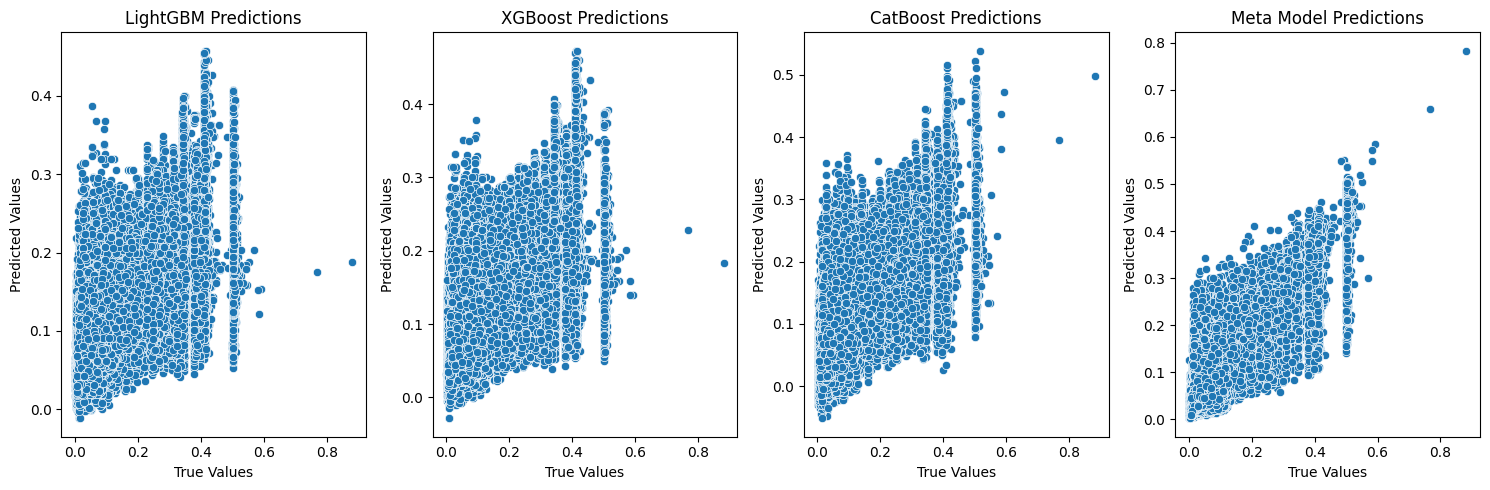

In [ ]:
plt.figure(figsize=(15, 5))
# LightGBM
plt.subplot(1, 4, 1)
sns.scatterplot(x=y_test, y=lgbm_pred)
plt.title("LightGBM Predictions")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.subplot(1, 4, 2)
sns.scatterplot(x=y_test, y=xgb_pred)
plt.title("XGBoost Predictions")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.subplot(1, 4, 3)
sns.scatterplot(x=y_test, y=cat_pred)
plt.title("CatBoost Predictions")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.subplot(1, 4, 4)
sns.scatterplot(x=y_test, y=meta_model_pred)
plt.title("Meta Model Predictions")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.tight_layout()
plt.show()